## Chapter 14 - Exercise 10

Build a CNN from scratch and try and achieve the highest possible accuracy on MNIST.

In [17]:
import os
from tensorflow.data import TFRecordDataset
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# build the input pipeline, apply the appropriate preprocessing operations and
# optionally add data augmentation
root_dir = "./datasets/horse_breeds"
class_names = ["Akhal-Teke", "Appalossa", "Orlov Trotter", "Vladimir Heavy Draft",
               "Percheron", "Arabian", "Friesian"]

def parse_tfrecord(tfrecord):
    feature_description = {
        "image": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)
        }
    example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    label = example["label"]
    
    return image, label


def horse_breed_dataset(filepath, batch_size=32, cache=True, shuffle=True):
    dataset = TFRecordDataset(filepath)
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=42)
    dataset = dataset.map(parse_tfrecord)
    # dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

train_set_raw = horse_breed_dataset(os.path.join(root_dir, 'train.tfrecord'))
val_set_raw = horse_breed_dataset(os.path.join(root_dir, 'val.tfrecord'), shuffle=True)
test_set_raw = horse_breed_dataset(os.path.join(root_dir, 'test.tfrecord'), shuffle=False)

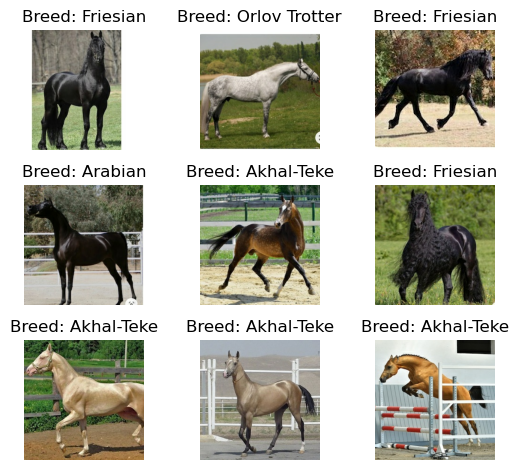

In [9]:
idx = 0
for img, label in val_set_raw.take(9):
    idx += 1
    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.title(f"Breed: {class_names[label]}")
    plt.axis("off")
    plt.tight_layout()

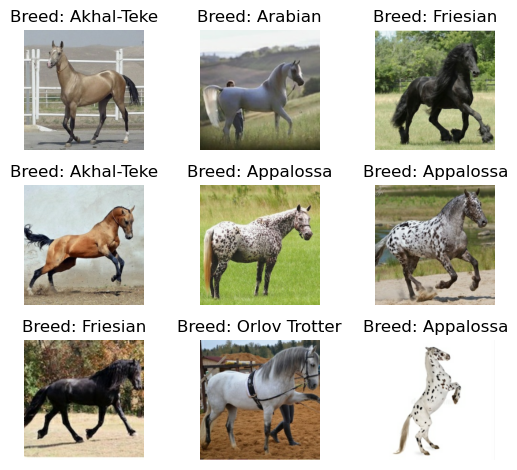

In [11]:
tfk.backend.clear_session()
batch_size = 32
preprocess = tfk.models.Sequential([
    tfk.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tfk.layers.Lambda(tfk.applications.efficientnet_v2.preprocess_input)
    ])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

for X_batch, y_batch in val_set.take(1):
    for idx in range(9):
        plt.subplot(3, 3, idx+1)
        plt.imshow(X_batch[idx])
        plt.title(f"Breed: {class_names[y_batch[idx]]}")
        plt.axis("off")
        plt.tight_layout()

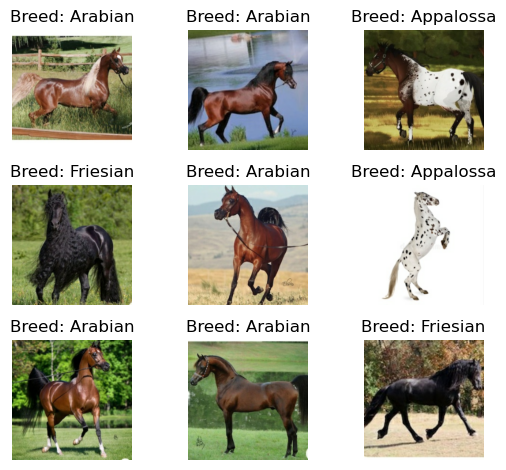

In [14]:
data_augmentation = tfk.Sequential([
    tfk.layers.RandomFlip(mode="horizontal", seed=42),
    tfk.layers.RandomContrast(factor=0.2, seed=42),
    tfk.layers.RandomBrightness(factor=0.2, seed=42)
    ])

for X_batch, y_batch in val_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for idx in range(9):
        plt.subplot(3, 3, idx+1)
        plt.imshow(np.clip(X_batch[idx], 0, 1))
        plt.title(f"Breed: {class_names[y_batch[idx]]}")
        plt.axis("off")
        plt.tight_layout()

350926856/350926856 [==============================] - 5s 0us/step
Epoch 1/10
15/15 [==============================] - 46s 2s/step - loss: 1.5123 - accuracy: 0.4065 - val_loss: 1.0962 - val_accuracy: 0.4737
Epoch 2/10
15/15 [==============================] - 9s 580ms/step - loss: 0.8698 - accuracy: 0.6804 - val_loss: 0.7555 - val_accuracy: 0.7193
Epoch 3/10
15/15 [==============================] - 9s 584ms/step - loss: 0.6591 - accuracy: 0.7739 - val_loss: 0.6582 - val_accuracy: 0.7719
Epoch 4/10
15/15 [==============================] - 9s 582ms/step - loss: 0.5566 - accuracy: 0.8022 - val_loss: 0.5732 - val_accuracy: 0.7719
Epoch 5/10
15/15 [==============================] - 9s 582ms/step - loss: 0.4893 - accuracy: 0.8370 - val_loss: 0.6104 - val_accuracy: 0.7544
Epoch 6/10
15/15 [==============================] - 9s 582ms/step - loss: 0.4274 - accuracy: 0.8674 - val_loss: 0.5468 - val_accuracy: 0.7719
Epoch 7/10
15/15 [==============================] - 9s 585ms/step - loss: 0.3946 - 

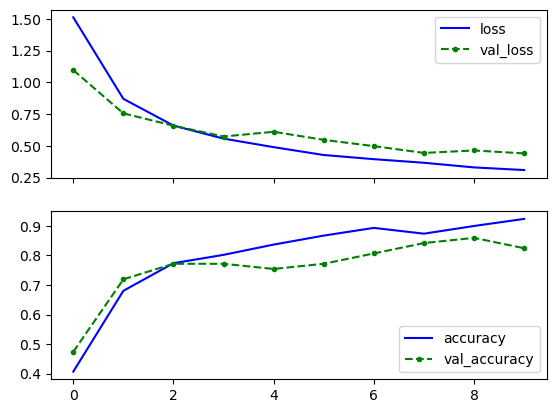

In [18]:
# fine-tune a pretrained model on this dataset
# for _, y_batch in train_set:
#     num_classes = len(np.unique(y_batch))
num_classes = len(class_names)

tfk.backend.clear_session()
tf.random.set_seed(42)
base_model = tfk.applications.convnext.ConvNeXtBase(
    weights="imagenet", include_top=False)
avg = tfk.layers.GlobalAveragePooling2D()(base_model.output)
output = tfk.layers.Dense(num_classes, activation="softmax")(avg)
model = tfk.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
optimiser = tfk.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimiser,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=val_set, epochs=10)

def plot_fit_history(fit_history):
    history_df = pd.DataFrame(fit_history.history)
    fig, axs = plt.subplots(2, 1, sharex=True)
    history_df[["loss", "val_loss"]].plot(ax=axs[0], style=["b-", "g--."])
    history_df[["accuracy", "val_accuracy"]].plot(ax=axs[1], style=["b-", "g--."])
    
plot_fit_history(history)

In [20]:
len(base_model.layers)

295

In [19]:
base_model.layers

Epoch 1/30
15/15 [==============================] - 36s 1s/step - loss: 0.2680 - accuracy: 0.9500 - val_loss: 2.3056 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - 10s 702ms/step - loss: 0.1260 - accuracy: 0.9739 - val_loss: 0.4693 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 3/30
15/15 [==============================] - 10s 684ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.4710 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
15/15 [==============================] - 10s 688ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5802 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 5/30
15/15 [==============================] - 10s 687ms/step - loss: 2.9576e-04 - accuracy: 1.0000 - val_loss: 0.5968 - val_accuracy: 0.8421 - lr: 3.0000e-04
Epoch 6/30
15/15 [==============================] - ETA:

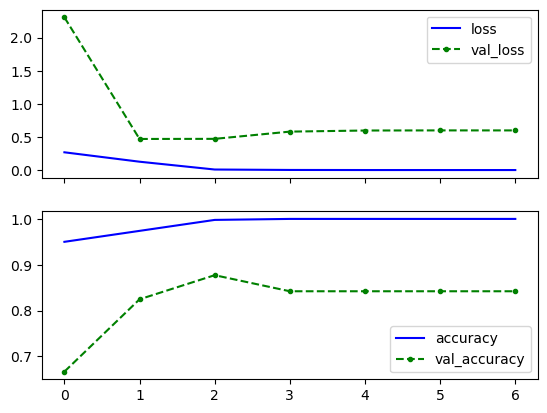

In [28]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

optimiser = tfk.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimiser,
              metrics=["accuracy"])

reduce_lr_cb = tfk.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, verbose=1,
                                               patience=2, min_lr=1e-8)
early_stopping_cb = tfk.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                                restore_best_weights=True)
history = model.fit(train_set, validation_data=val_set, epochs=30,
                    callbacks=[reduce_lr_cb, early_stopping_cb])

plot_fit_history(history)